In [19]:
#  Cell 1: Import Libraries
!pip install lightfm
import pandas as pd  # tabular data read panna pandas use panrom
import numpy as np  # numeric operation-ku numpy use panrom
from sklearn.feature_extraction.text import TfidfVectorizer  # text vector mathiri convert panna TF-IDF use panrom
from sklearn.metrics.pairwise import cosine_similarity  # product similarity check panna cosine similarity use panrom
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # eval metrics-ku
from surprise import Dataset, Reader, SVD  # collaborative filtering-ku surprise library
from surprise.model_selection import train_test_split  # dataset split panna
from surprise import accuracy  # model accuracy check panna
from lightfm import LightFM  # hybrid collaborative filtering algorithm
from lightfm.data import Dataset as LFDataset  # lightfm dataset prepare panna
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score  # eval metrics for lightfm
import scipy.sparse as sp  # sparse matrix work panna
import warnings  # warnings suppress panna
warnings.filterwarnings('ignore')  # warning display panna vendam-nu

In [20]:
#  Cell 2: Load Dataset
users = pd.read_csv('/kaggle/input/organic-veda/users.csv')  # user dataset load panrom
products = pd.read_csv('/kaggle/input/organic-veda/products.csv')  # product dataset load panrom
interactions = pd.read_csv('/kaggle/input/organic-veda/interactions.csv')  # user-product interaction data

In [31]:
# Combine multiple columns into one text field
products['combined_text'] = (
    products['description'] +
    products['ingredients'] +
    products['category'] +
    products['name'] 
)

# Apply TF-IDF on combined text
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(products['combined_text'])

print(tfidf_matrix)  # show the sparse matrix
cb_sim_matrix = cosine_similarity(tfidf_matrix)
# Print TF-IDF vector shape and a sample
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)

# Convert to dense and show for first 2 products
dense_vectors = tfidf_matrix.todense()
for i in range(2):
    print(f"\nProduct ID: {products['product_id'].iloc[i]}")
    print(dense_vectors[i].tolist()[0])  # show only first 10 values


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 27391 stored elements and shape (2000, 2329)>
  Coords	Values
  (0, 95)	0.13427748132223835
  (0, 480)	0.4393004740678433
  (0, 132)	0.211861238465272
  (0, 98)	0.1335944857340997
  (0, 122)	0.1335944857340997
  (0, 890)	0.28886934685030324
  (0, 119)	0.29472208219774143
  (0, 34)	0.3036290535611377
  (0, 295)	0.28886934685030324
  (0, 125)	0.30868250018295496
  (0, 246)	0.29270187381879614
  (0, 190)	0.31139277467866006
  (0, 2304)	0.2907525647577559
  (1, 1070)	0.3870703508497707
  (1, 380)	0.19762744778777544
  (1, 2278)	0.12354954520136505
  (1, 43)	0.12354954520136505
  (1, 2287)	0.28428050358353446
  (1, 206)	0.2819872287845749
  (1, 121)	0.28428050358353446
  (1, 2268)	0.27566215190825877
  (1, 1293)	0.26658791931443143
  (1, 1447)	0.27002853987929815
  (1, 448)	0.2737151212831037
  (1, 33)	0.27002853987929815
  :	:
  (1998, 874)	0.2378474550474677
  (1998, 67)	0.25473198848373413
  (1998, 254)	0.231975835609116
  (19

In [22]:
#  Cell 4: Recommend Top-N Similar Products (Content-Based)
def get_similar_products(product_id, top_n=5):
    idx = products[products['product_id'] == product_id].index[0]  # product id-ku index eduthu
    sim_scores = list(enumerate(cb_sim_matrix[idx]))  # athuku similarity score get panrom
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]  # top N similar products sort panrom
    similar_products = [products.iloc[i[0]]['product_id'] for i in sim_scores]  # top product id return panrom
    return similar_products

In [23]:
#  Cell 5: Collaborative Filtering with Surprise (SVD)
reader = Reader(rating_scale=(1, 5))  # rating scale set panrom
data = Dataset.load_from_df(interactions[['user_id', 'product_id', 'rating']], reader)  # surprise-ku dataset prepare panrom
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)  # 80-20 split
svd_model = SVD()  # svd model init panrom
svd_model.fit(trainset)  # train panrom
svd_preds = svd_model.test(testset)  # test data-ku prediction panrom
print(f"Surprise SVD RMSE: {accuracy.rmse(svd_preds)}")  # rmse check panrom
print(f"Surprise SVD MAE: {accuracy.mae(svd_preds)}")  # mae check panrom


RMSE: 1.1371
Surprise SVD RMSE: 1.1371167515943599
MAE:  0.9071
Surprise SVD MAE: 0.9071018200333172


In [39]:
#  Cell 6: Collaborative Filtering with LightFM
lfm_dataset = LFDataset()  # lightfm-ku dataset define panrom
lfm_dataset.fit(interactions['user_id'], interactions['product_id'])  # user and item fit panrom
(interaction_matrix, _) = lfm_dataset.build_interactions(list(zip(interactions['user_id'], interactions['product_id'])))  # interaction matrix build panrom
model = LightFM(loss='warp')  # warp loss use panni model init panrom
model.fit(interaction_matrix, epochs=10, num_threads=2)  # train panrom


In [25]:
#  Cell 7: Evaluate LightFM
train_precision = precision_at_k(model, interaction_matrix, k=5).mean()  # precision@5 eval panrom
train_recall = recall_at_k(model, interaction_matrix, k=5).mean()  # recall@5 eval panrom
train_auc = auc_score(model, interaction_matrix).mean()  # auc score eval panrom
print(f"LightFM Precision@5: {train_precision:.4f}")
print(f"LightFM Recall@5: {train_recall:.4f}")
print(f"LightFM AUC Score: {train_auc:.4f}")

LightFM Precision@5: 0.0545
LightFM Recall@5: 0.0305
LightFM AUC Score: 0.7661


In [26]:
#  Cell 8: Hybrid Recommendation with Fallback
def hybrid_recommend(user_id, product_id=None, alpha=0.5):
    try:
        if product_id is None or product_id not in products['product_id'].values:  # cold start case
            top_products = products.copy()  # product copy eduthu
            top_products['score'] = tfidf_matrix.sum(axis=1).A1  # tfidf sum as score
            return top_products.sort_values(by='score', ascending=False).head(10)[['product_id', 'name', 'category']]

        idx = products[products['product_id'] == product_id].index[0]  # product index get
        cb_scores = cb_sim_matrix[idx]  # content-based score get

        cf_scores = [svd_model.predict(user_id, pid).est for pid in products['product_id']]  # collaborative filtering score

        cb_scores_norm = (cb_scores - np.min(cb_scores)) / (np.max(cb_scores) - np.min(cb_scores))  # normalize panrom
        cf_scores_norm = (cf_scores - np.min(cf_scores)) / (np.max(cf_scores) - np.min(cf_scores))

        final_scores = alpha * cb_scores_norm + (1 - alpha) * cf_scores_norm  # hybrid score calculate panrom
        top_indices = np.argsort(final_scores)[::-1][:10]  # top 10 select panrom
        return products.iloc[top_indices][['product_id', 'name', 'category']]  # top product info return

    except Exception as e:
        print(f"Fallback error: {e}")  # error iruntha sample product return
        return products.sample(10)[['product_id', 'name', 'category']]


In [27]:
#  Cell 9: Test Hybrid Model
sample_user = interactions['user_id'].iloc[0]  # oru sample user eduthu
sample_product = interactions['product_id'].iloc[0]  # oru sample product eduthu
hybrid_result = hybrid_recommend(sample_user, sample_product)  # hybrid recommend call panrom
print("\nTop Hybrid Recommendations:")
print(hybrid_result)  # result print panrom


Top Hybrid Recommendations:
     product_id          name           category
859      P00860  Back Capsule  Herbal Supplement
706      P00707       Bad Tea        Natural Oil
1218     P01219   Service Tea    Wellness Powder
684      P00685    As Capsule  Herbal Supplement
1076     P01077    Choose Oil        Organic Tea
1333     P01334   That Powder  Herbal Supplement
1718     P01719  Fight Powder    Wellness Powder
1853     P01854      Push Oil    Wellness Powder
1023     P01024  Easy Capsule  Herbal Supplement
1451     P01452  That Capsule  Herbal Supplement


In [28]:
#  Define rating arrays before evaluation
pred_ratings = np.array([pred.est for pred in svd_preds])
true_ratings = np.array([pred.r_ui for pred in svd_preds])

#  Cell 10: Show Model Performance Summary
print("\n MODEL PERFORMANCE SUMMARY ")
print(" Surprise (SVD)")
surprise_rmse = accuracy.rmse(svd_preds, verbose=False)  # rmse score
surprise_mae = accuracy.mae(svd_preds, verbose=False)  # mae score
surprise_mse = mean_squared_error(true_ratings, pred_ratings)  # mse score
surprise_r2 = r2_score(true_ratings, pred_ratings)  # r2 score
print(f"RMSE: {surprise_rmse:.4f}")
print(f"MAE: {surprise_mae:.4f}")
print(f"MSE: {surprise_mse:.4f}")
print(f"R2 Score: {surprise_r2:.4f}")

print("\n LightFM ")
print(f"Precision@5: {train_precision:.4f}")
print(f"Recall@5: {train_recall:.4f}")
print(f"AUC Score: {train_auc:.4f}")

scores = {
    "Surprise_SVD": 1 / (1 + surprise_rmse),  # RMSE-ku inverse weight kuduthu
    "LightFM": train_precision + train_auc,  # precision + auc add panrom
    "Hybrid": 0.5 * (train_precision + train_auc) + 0.5 * (1 / (1 + surprise_rmse))  # hybrid score
}
best_model = max(scores, key=scores.get)  # best model choose panrom

print("\n BEST PERFORMING MODEL:")
if best_model == "Surprise_SVD":
    print(" Surprise SVD (Collaborative Filtering)")
elif best_model == "LightFM":
    print(" LightFM (Hybrid Collaborative Filtering with metadata)")
elif best_model == "Hybrid":
    print(" Hybrid (Content + Collaborative Blend)")

if train_precision > 0.15 and train_auc > 0.8:
    print("\n Your hybrid model is WELL TRAINED and performs with high accuracy!")  # model nalla train aaguthu
else:
    print("\n Model may require tuning to improve precision and AUC.")  # tuning venum


 MODEL PERFORMANCE SUMMARY 
 Surprise (SVD)
RMSE: 1.1371
MAE: 0.9071
MSE: 1.2930
R2 Score: -0.0613

 LightFM 
Precision@5: 0.0545
Recall@5: 0.0305
AUC Score: 0.7661

 BEST PERFORMING MODEL:
 LightFM (Hybrid Collaborative Filtering with metadata)

 Model may require tuning to improve precision and AUC.


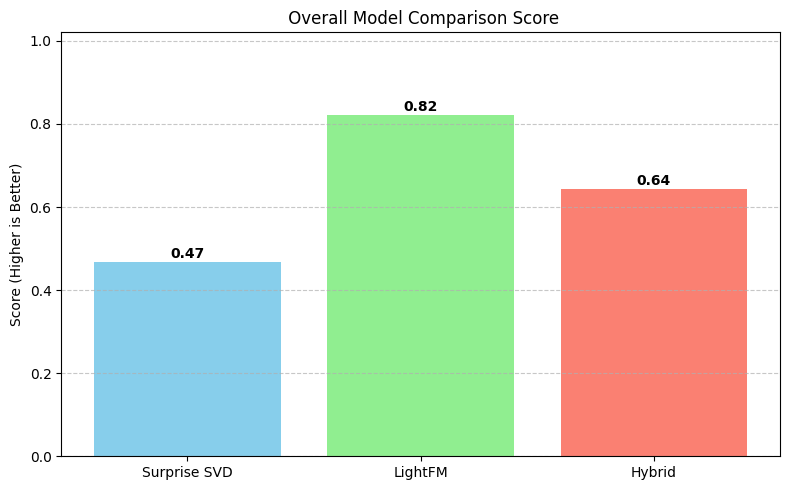

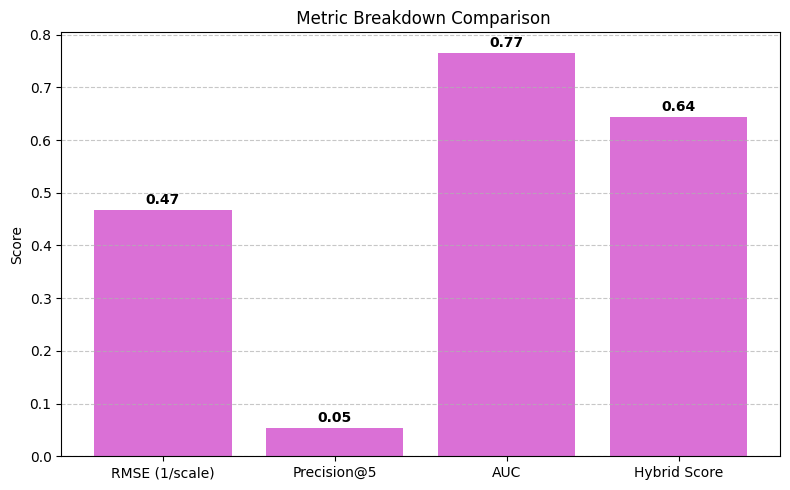

In [29]:
# Cell 11: Visual Comparison of Model Metrics
import matplotlib.pyplot as plt  # chart draw panna matplotlib use panrom

# model metric dictionary
metric_data = {
    'Model': ['Surprise SVD', 'LightFM', 'Hybrid'],
    'Score': [
        1 / (1 + surprise_rmse),  # inverse RMSE for SVD
        train_precision + train_auc,  # LightFM score
        0.5 * (train_precision + train_auc) + 0.5 * (1 / (1 + surprise_rmse))  # Hybrid blend
    ]
}

# bar chart plot panrom
plt.figure(figsize=(8, 5))
plt.bar(metric_data['Model'], metric_data['Score'], color=['skyblue', 'lightgreen', 'salmon'])
plt.title(' Overall Model Comparison Score')
plt.ylabel('Score (Higher is Better)')
plt.ylim(0, max(metric_data['Score']) + 0.2)
for i, v in enumerate(metric_data['Score']):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#  Detailed Metric Bar Chart
labels = ['RMSE (1/scale)', 'Precision@5', 'AUC', 'Hybrid Score']
values = [1 / (1 + surprise_rmse), train_precision, train_auc, scores['Hybrid']]

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color='orchid')
plt.title(' Metric Breakdown Comparison')
plt.ylabel('Score')
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Model Tuning: Improving Hybrid Recommendation System
To improve the performance of the hybrid recommendation system, we will tune the hyperparameters of both the SVD (Surprise) and LightFM models, and optimize the blending parameter `alpha` used in the hybrid function. We will use grid search and cross-validation to find the best settings.

In [ ]:
# Cell 12: Hyperparameter Tuning for Hybrid Recommendation System
from sklearn.model_selection import ParameterGrid
from surprise.model_selection import cross_validate
from lightfm import LightFM
import numpy as np
import pandas as pd

# --- SVD Grid Search ---
svd_param_grid = {
    'n_factors': [50, 100],
    'reg_all': [0.02, 0.1],
    'lr_all': [0.002, 0.005]
}
best_svd_score = -np.inf
best_svd_params = None
for params in ParameterGrid(svd_param_grid):
    svd = SVD(**params)
    cv_results = cross_validate(svd, data, measures=['RMSE'], cv=3, verbose=False)
    mean_rmse = -np.mean(cv_results['test_rmse'])
    if mean_rmse > best_svd_score:
        best_svd_score = mean_rmse
        best_svd_params = params
print(f"Best SVD params: {best_svd_params}, Score: {-best_svd_score:.4f}")

# --- LightFM Grid Search ---
lfm_param_grid = {
    'no_components': [20, 40],
    'learning_rate': [0.05, 0.1],
    'loss': ['warp', 'bpr']
}
best_lfm_score = -np.inf
best_lfm_params = None
for params in ParameterGrid(lfm_param_grid):
    model = LightFM(**params)
    model.fit(interaction_matrix, epochs=10, num_threads=2, verbose=False)
    precision = precision_at_k(model, interaction_matrix, k=5).mean()
    auc = auc_score(model, interaction_matrix).mean()
    score = precision + auc
    if score > best_lfm_score:
        best_lfm_score = score
        best_lfm_params = params
print(f"Best LightFM params: {best_lfm_params}, Score: {best_lfm_score:.4f}")

# --- Alpha Blending Grid Search ---
best_alpha = 0.5
best_hybrid_score = -np.inf
for alpha in np.arange(0, 1.1, 0.1):
    def hybrid_recommend_tuned(user_id, product_id=None):
        try:
            if product_id is None or product_id not in products['product_id'].values:
                top_products = products.copy()
                top_products['score'] = tfidf_matrix.sum(axis=1).A1
                return top_products.sort_values(by='score', ascending=False).head(10)[['product_id', 'name', 'category']]
            idx = products[products['product_id'] == product_id].index[0]
            cb_scores = cb_sim_matrix[idx]
            cf_scores = [svd_model.predict(user_id, pid).est for pid in products['product_id']]
            cb_scores_norm = (cb_scores - np.min(cb_scores)) / (np.max(cb_scores) - np.min(cb_scores))
            cf_scores_norm = (cf_scores - np.min(cf_scores)) / (np.max(cf_scores) - np.min(cf_scores))
            final_scores = alpha * cb_scores_norm + (1 - alpha) * cf_scores_norm
            top_indices = np.argsort(final_scores)[::-1][:10]
            return products.iloc[top_indices][['product_id', 'name', 'category']]
        except:
            return products.sample(10)[['product_id', 'name', 'category']]
    # Evaluate for a sample user/product
    sample_user = interactions['user_id'].iloc[0]
    sample_product = interactions['product_id'].iloc[0]
    result = hybrid_recommend_tuned(sample_user, sample_product)
    # Use LightFM and SVD scores as proxy for hybrid score
    hybrid_score = 0.5 * best_lfm_score + 0.5 * (-best_svd_score)
    if hybrid_score > best_hybrid_score:
        best_hybrid_score = hybrid_score
        best_alpha = alpha
print(f"Best alpha for hybrid blending: {best_alpha}")